# LDA para o Referencial Curricular de Alagoas para Educação Infantil e Ensino Fundamental:

## Importação das bibliotecas:

In [1]:
# Para ler o PDF:
import PyPDF2

# Para analisar o layout do PDF e extrair o texto:
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure

# Para extrair textos de tabelas em PDF:
import pdfplumber

# Para extrair as imagens dos PDFs:
from PIL import Image
from pdf2image import convert_from_path

# Para fazer Reconhecimento Ótico de Caracteres (OCR) para extrair textos das imagens:
import pytesseract

# Para remover os arquivos adicionais criados:
import os

# Para manipulação e análise dos dados:
import pandas as pd
import numpy as np
from collections import Counter

# Para acompanhar a execução dos códigos:
from tqdm import tqdm

# Para análise dos dados textuais:
import re
import nltk
import spacy
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

# Para visualizações:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Download do modelo para língua portuguesa:
spacy.cli.download("pt_core_news_lg")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [3]:
# Carregamento do modelo:
nlp = spacy.load('pt_core_news_lg')

## 1. Extração das informações do PDF:

In [4]:
# Caminho do arquivo em PDF:
pdf_path = r"C:\Users\hugob\Dropbox\Hugo_Bovareto\Dissertação PROFIAP\LDA\AL\AL_curriculo_EIEF.pdf"

In [5]:
# Função para extração do texto:

def text_extraction(element):
    # Extrair texto:
    line_text = element.get_text()

    # Encontrar o formato do texto:
    # Iniciar a lista com todos os formatos que aparecem nas linhas de texto:
    line_formats = []
    for text_line in element:
        if isinstance(text_line, LTTextContainer):
            # Iterar cada caracter do texto:
            for character in text_line:
                if isinstance(character, LTChar):
                    # Acrescentar o nome da fonte do caracter:
                    line_formats.append(character.fontname)
                    # Acrescentar o tamanho da fonte do caracter:
                    line_formats.append(character.size)
    # Lista de tamanho e nome da fonte dos textos:
    format_per_line = list(set(line_formats))

    # Retornar uma tupla com o texto em cada linha e o seu formato:
    return (line_text, format_per_line)

In [6]:
# Criar uma função que corta as imagens do PDF:
def crop_image(element, pageObj):
    # Conseguir as coordenados para identificar as imagens no PDF:
    [image_left, image_top, image_right, image_bottom] = [element.x0,element.y0,element.x1,element.y1]
    # Cortar a página usando as coordenadas:
    pageObj.mediabox.lower_left = (image_left, image_bottom)
    pageObj.mediabox.upper_right = (image_right, image_top)
    # Salvar a imagem cortada em um novo arquivo PDF:
    cropped_pdf_writer = PyPDF2.PdfWriter()
    cropped_pdf_writer.add_page(pageObj)
    # Salvar o PDF cortado em um novo arquivo:
    with open('cropped_image.pdf', 'wb') as cropped_pdf_file:
        cropped_pdf_writer.write(cropped_pdf_file)

# Criar uma função para converter o PDF em imagens:
def convert_to_images(input_file,):
    images = convert_from_path(input_file, poppler_path=r'D:\Program Files\poppler-23.11.0\Library\bin')
    image = images[0]
    output_file = "PDF_image.png"
    image.save(output_file, "PNG")

# Criar uma função para ler texto das imagens:
def image_to_text(image_path):
    # Ler a imagem:
    img = Image.open(image_path)
    # Extrair o texto da imagem:
    text = pytesseract.image_to_string(img)
    return text

In [7]:
# Extrair tabelas de uma página:

def extract_table(pdf_path, page_num, table_num):
    # Abrir o arquivo em PDF:
    pdf = pdfplumber.open(pdf_path)
    # Encontrar a página:
    table_page = pdf.pages[page_num]
    # Extrair as tabelas:
    table = table_page.extract_tables()[table_num]
    return table

# Converter a tabela em formato apropriado:
def table_converter(table):
    table_string = ''
    # Iterar cada linha da tabela:
    for row_num in range(len(table)):
        row = table[row_num]
        # Remover o separador de linhas de textos quebrados:
        cleaned_row = [item.replace('\n', ' ') if item is not None and '\n' in item else 'None' if item is None else item for item in row]
        # Converter uma tabeça em uma strnig:
        table_string+=('|'+'|'.join(cleaned_row)+'|'+'\n')
    # Remover o último separados de linhas:
    table_string = table_string[:-1]
    return table_string

In [8]:
# Criar um objeto para o arquivo em PDF:
pdfFileObj = open(pdf_path, 'rb')
# Criar um objeto leitor de PDF:
pdfReaded = PyPDF2.PdfReader(pdfFileObj)

# Criar um dicionário para extrair texto de cada imagem:
text_per_page = {}
# Extrair as páginas do PDF:
for pagenum, page in tqdm(enumerate(extract_pages(pdf_path))):

    # Iniciar as variáveis necessárias para extração dos textos de cada página:
    pageObj = pdfReaded.pages[pagenum]
    page_text = []
    line_format = []
    text_from_images = []
    text_from_tables = []
    page_content = []
    # Iniciar o número de tabelas examinadas:
    table_num = 0
    first_element= True
    table_extraction_flag= False
    # Abrir o arquivo em PDF:
    pdf = pdfplumber.open(pdf_path)
    # Encontrar a página examinada:
    page_tables = pdf.pages[pagenum]
    # Encontrar o número de tabelas na página:
    tables = page_tables.find_tables()


    # Encontrar todos os elementos:
    page_elements = [(element.y1, element) for element in page._objs]
    # Classificar os elementos conforme aparecem na página:
    page_elements.sort(key=lambda a: a[0], reverse=True)
    
    lower_side = 0.0
    upper_side = 0.0
    
    # Encontrar os elementos que compõem a página:
    for i,component in enumerate(page_elements):
        # Extrair a posição do elemento:
        pos= component[0]
        # Extrair o elemento do payout da página:
        element = component[1]

        # Checar se o elemento é um texto:
        if isinstance(element, LTTextContainer):
            # Checar se o texto está em uma tabela:
            if table_extraction_flag == False:
                # Extrair o texto e formato de cada elemento textual:
                (line_text, format_per_line) = text_extraction(element)
                # Acrescentar o texto de cada linha:
                page_text.append(line_text)
                # Acrescentar o formato de cada linha contendo texto:
                line_format.append(format_per_line)
                page_content.append(line_text)
            else:
                # Omissão para textos que aparecem em imagens e tabelas:
                pass

        # Checar se o elemento é uma imagem:
        if isinstance(element, LTFigure):
            # Cortar a imagem do arquivo em PDF:
            crop_image(element, pageObj)
            # Converter o PDF cortado em uma imagem:
            convert_to_images('cropped_image.pdf')
            # Extrair o texto da imagem:
            image_text = image_to_text('PDF_image.png')
            text_from_images.append(image_text)
            page_content.append(image_text)
            # Reservar um espaço para lista de textos e formatos:
            page_text.append('image')
            line_format.append('image')

        # Checar os elementos das tabelas:
        if isinstance(element, LTRect):
            # Se o primeiro elementos é retangular:
            if first_element == True and (table_num+1) <= len(tables):
                # Encontrar os limites da tabela:
                lower_side = page.bbox[3] - tables[table_num].bbox[3]
                upper_side = element.y1
                # Extrair as informações da tabela:
                table = extract_table(pdf_path, pagenum, table_num)
                # Converter a informação da tabela em um formato de string:
                table_string = table_converter(table)
                # Adicionar os textos da tabela em uma lista:
                text_from_tables.append(table_string)
                page_content.append(table_string)
                # Definir como 'Verdadeiro' para evitar o conteúdo novamente:
                table_extraction_flag = True
                # Fazer o processo com outro elemento:
                first_element = False
                # Reservar um espaço para lista de textos e formatos:
                page_text.append('table')
                line_format.append('table')

            # Checar se já extraiu as tabelas da página:
            if i + 1 < len(page_elements) and element.y0 >= lower_side and element.y1 <= upper_side:
                pass
            elif i + 1 < len(page_elements) and not isinstance(page_elements[i + 1][1], LTRect):
                table_extraction_flag = False
                first_element = True
                table_num += 1                

    # Criar as páginas como chaves do dicionário:
    dctkey = 'Page_'+str(pagenum)
    # Adicionar as listas como valores para a chave (página do PDF) do dicionário:
    text_per_page[dctkey]= [page_text, line_format, text_from_images,text_from_tables, page_content]
    
# Fechar o objeto do arquivo PDF:
pdfFileObj.close()

# Deletar os arquivos adicionais criados:
os.remove('cropped_image.pdf')
os.remove('PDF_image.png')

882it [22:26,  1.53s/it]


O resultado do processo é armazenado em um dicionário com uma chave para cada página do arquivo PDF e 5 listas para os valores dessa chave. São elas:
[0] 'page_text': contém o texto proveniente dos elementos de texto do PDF;

[1] 'line_format': comtém os formatos dos textos extraídos no elemento acima;

[2] 'text_from_images': comtém os textos extraídos de imagens;

[3] 'text_from_tables': contém os textos das tabelas;

[4] 'page_content': contém todos os textos renderizados na página em uma lista de elementos.

A última lista ('[4] page_content') é o elemento usado para a análise dos textos aqui, pois possui todos os textos extraídos do PDF.

In [10]:
# Criar um DataFrame a partir do dicionário com a 5ª lista ('page_content') do Valor:
df = pd.DataFrame({'Chave': list(text_per_page.keys()),
                   'Valor': [valor[4] for valor in text_per_page.values()]})

# Exibir o DataFrame:
df

Chave                                              Valor
0      Page_0  [||\n|Referencial Curricular de Alagoas|\n|Edu...
1      Page_1                                                 []
2      Page_2  [, (Fonte: Agência Alagoas – Foto: Márcio Ferr...
3      Page_3                                                 []
4      Page_4  [GOVERNO DE ALAGOAS\nSecretaria de Estado da E...
..        ...                                                ...
877  Page_877  [III  - Desenvolver o senso estético para reco...
878  Page_878  [dois blocos distintos, devendo ser planejados...
879  Page_879  [Art. 9º. Para atender o disposto na meta 5 do...
880  Page_880  [so de implantação do Referencial Curricular d...
881  Page_881                                                 []

[882 rows x 2 columns]

## 2. Pré-processamento dos dados:

### Retirar as páginas que identifiquei que não tem nada de relevante para o conteúdo dos documentos (ex.: sumários, capas, ficha técnica, referências etc):

In [37]:
# Índices das linhas que você deseja excluir
indices_para_excluir = list(range(0, 14)) + list(range(123, 144)) + list(range(144, 162)) + list(range(162, 194)) + list(range(202, 204)) + list(range(247, 249)) + list(range(401, 404)) + list(range(504, 510)) + list(range(550, 554)) + list(range(603, 606)) + list(range(688, 696)) + list(range(761, 766)) + list(range(810, 812)) + list(range(858, 882))

# Usando o método drop para excluir as linhas
df = df.drop(indices_para_excluir)

# Reiniciar os índices se necessário
df = df.reset_index(drop=True)

In [38]:
df

Chave                                              Valor
0     Page_14  [||ALAGOAS, UM|\n||TERRITÓRIO DE|\n||APRENDIZA...
1     Page_15  [, 16\n, Mesorregiões de Alagoas\n, Mesorregiã...
2     Page_16  [, 17\n, O povo de Alagoas tem caracte-\nrísti...
3     Page_17  [, 18\n, Povos Indígenas e Quilombolas \n, Pov...
4     Page_18  [, 19\n, A  seguir,  apresentaremos  perspecti...
..        ...                                                ...
733  Page_853  [, 710\n, (EF07CI07) Caracterizar os principai...
734  Page_854  [, 711\n, ORGANIZADOR CURRICULAR DE CIÊNCIAS D...
735  Page_855  [, 712\n, Reconhecer o sistema reprodutivo das...
736  Page_856  [, 713\n, ORGANIZADOR CURRICULAR DE CIÊNCIAS D...
737  Page_857  [, 714\n, das \n, (EF09CI08) Associar os gamet...

[738 rows x 2 columns]

In [39]:
# Salvar o DataFrame:
import pickle
df.to_pickle("AL_paginas.pkl")

In [2]:
import pickle

with open("AL_paginas.pkl", 'rb') as file:
    # Carregar o conteúdo do arquivo pickled
    dados = pickle.load(file)

### Separação e tokenização das frases:

As análises serão feitas separando os textos por frases.

In [40]:
from nltk.tokenize import sent_tokenize

In [41]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hugob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [42]:
# Função para separar as frases de cada página:
def separar_frases(texto):
    return sent_tokenize(texto, language='portuguese')

In [43]:
# Método apply para aplicar a função em cada linha:
df['frases'] = df['Valor'].astype(str).apply(separar_frases)

In [44]:
# Expandir cada frase em uma linha e criar um novo dataframe:
df = pd.DataFrame(df['frases'].explode().reset_index(drop=True))

### Exclusão de sinalização de parágrafos, sinalização de falta de valor e junção de palavras cortadas entre linhas:

In [45]:
# Junção de palavras cortadas entre linhas (possuem '-\n' entre a palavra):

df['frases'] = df['frases'].str.replace(r'-\n', '')

In [46]:
#Exclusão de sinalização de parágrafos (\n):
df['frases'] = df['frases'].str.replace(r'\n', '')

In [47]:
#Exclusão de sinalização de falta de valor ('None'):
df['frases'] = df['frases'].str.replace(r'None', '')

### Pré-processamento:

In [48]:
# Função para pré-processar o texto:
def preprocessar_texto(texto):
    preprocessado = simple_preprocess(texto, deacc=True, min_len=3, max_len=50)
    return preprocessado

In [49]:
# Aplicar a função de pré-processamento para criar a nova coluna:
df['Preprocessado'] = df['frases'].apply(preprocessar_texto)

In [50]:
# Excluir palavras indesejadas:
# "chs" está sendo gerado na identificação das habilidades;

# Função para remover strings específicas das listas:
def remover_string(lista):
    for string_inutil in strings_inuteis:
        if string_inutil in lista:
            lista.remove(string_inutil)
    return lista

strings_inuteis = ["chs"]

In [51]:
# Aplicar a função à coluna do DataFrame
df['Preprocessado'] = df['Preprocessado'].apply(remover_string)

### Remover Stop words:

In [52]:
# Stop words da biblioteca Spacy:
stopwords_spacy = spacy.lang.pt.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(stopwords_spacy))

Number of stop words: 416


In [53]:
# Função para remover as stop words:
def remover_stopwords_spacy(texto):
    return [palavra for palavra in texto if palavra not in stopwords_spacy]

In [54]:
df['Sem_stopwords'] = df['Preprocessado'].apply(remover_stopwords_spacy)

### Stemização:

Há várias opções de stemmers na biblioteca NLTK. Utilizaremos o RSLP que é específico para língua portuguesa.
(https://www.nltk.org/_modules/nltk/stem/rslp.html; https://dfalbel.github.io/rslp/)

In [59]:
from nltk.stem import RSLPStemmer

In [60]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\hugob\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [61]:
def stem_RSLPS(tokens):
    stemmer = RSLPStemmer()
    stem_tokens = [stemmer.stem(token) for token in tokens]
    return stem_tokens

In [62]:
df['Stem'] = df['Sem_stopwords'].apply(stem_RSLPS)

In [63]:
# Salvar o DataFrame:
df.to_pickle("AL_stem.pkl")

## 3. LDA:

In [64]:
# Criar o dicionário de palavras
dicionario = corpora.Dictionary(df['Stem'])

In [65]:
# Criar o corpus
corpus = [dicionario.doc2bow(text) for text in df['Stem']]

### Identificação do melhor valor para Coherence Score:

In [66]:
# Função para testar vários coherence scores e perplexities:

def compute_performance(dictionary, corpus, texts, limit, start, step):
    """
    Computa c_v coherence score para vários números de tópicos.

    Parâmetros:
    dicionário: dicionario;
    corpus: corpus;
    texts: lista de listas com as palavras pré-processadas do documento;
    limit: Máximo nº de tópicos;
    start: Nº de tópicos inicial;
    step: intervalo entre os nº de tópicos testados.

    Resultados:
    model_list: lista de modelos LDA.
    coherence_values: valores de coerência correspondentes ao modelo LDA com o respectivo nº de tópicos.
    """
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dicionario,
                         random_state=42,
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

    return model_list, coherence_values, perplexity_values

In [67]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=1,
                                                                           limit=102,
                                                                           step=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [11:46<00:00, 33.67s/it]


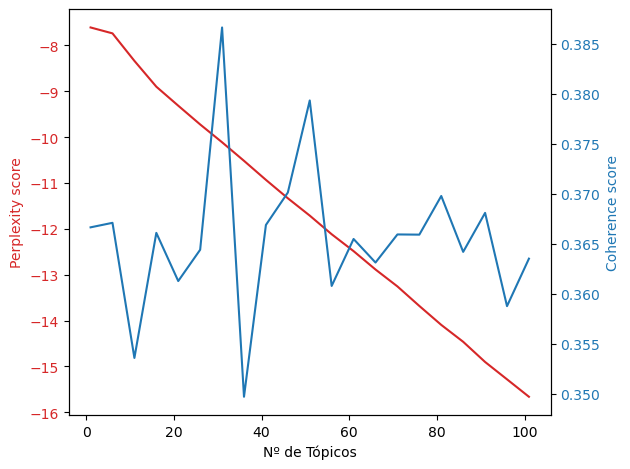

In [68]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=102; start=1; step=5;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('AL_Coherence Score_100 topicos.png')

plt.show()

In [69]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.3667  e valor de perplexidade de -7.6122
A quantidade de tópicos = 6  tem um valor de coerência de  0.3671  e valor de perplexidade de -7.741
A quantidade de tópicos = 11  tem um valor de coerência de  0.3536  e valor de perplexidade de -8.3402
A quantidade de tópicos = 16  tem um valor de coerência de  0.3661  e valor de perplexidade de -8.9028
A quantidade de tópicos = 21  tem um valor de coerência de  0.3613  e valor de perplexidade de -9.3171
A quantidade de tópicos = 26  tem um valor de coerência de  0.3644  e valor de perplexidade de -9.7257
A quantidade de tópicos = 31  tem um valor de coerência de  0.3866  e valor de perplexidade de -10.1142
A quantidade de tópicos = 36  tem um valor de coerência de  0.3497  e valor de perplexidade de -10.5185
A quantidade de tópicos = 41  tem um valor de coerência de  0.3669  e valor de perplexidade de -10.9335
A quantidade de tópicos = 46  tem um valor de coerência de  0.3701  e val

In [70]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=25,
                                                                           limit=41,
                                                                           step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [08:37<00:00, 32.35s/it]


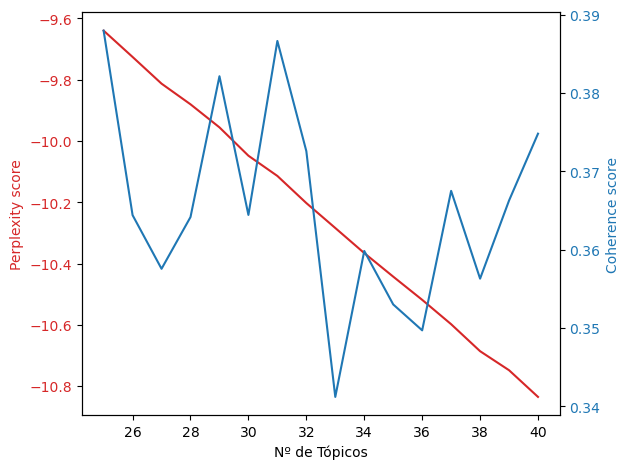

In [72]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=41; start=25; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('AL_Coherence Score_25 - 40 topicos.png')

plt.show()

In [73]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 25  tem um valor de coerência de  0.388  e valor de perplexidade de -9.6399
A quantidade de tópicos = 26  tem um valor de coerência de  0.3644  e valor de perplexidade de -9.7257
A quantidade de tópicos = 27  tem um valor de coerência de  0.3576  e valor de perplexidade de -9.8129
A quantidade de tópicos = 28  tem um valor de coerência de  0.3642  e valor de perplexidade de -9.8803
A quantidade de tópicos = 29  tem um valor de coerência de  0.3821  e valor de perplexidade de -9.9556
A quantidade de tópicos = 30  tem um valor de coerência de  0.3644  e valor de perplexidade de -10.0481
A quantidade de tópicos = 31  tem um valor de coerência de  0.3866  e valor de perplexidade de -10.1142
A quantidade de tópicos = 32  tem um valor de coerência de  0.3726  e valor de perplexidade de -10.2027
A quantidade de tópicos = 33  tem um valor de coerência de  0.3412  e valor de perplexidade de -10.2841
A quantidade de tópicos = 34  tem um valor de coerência de  0.3598  e 

In [76]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=45,
                                                                           limit=55,
                                                                           step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:30<00:00, 33.04s/it]


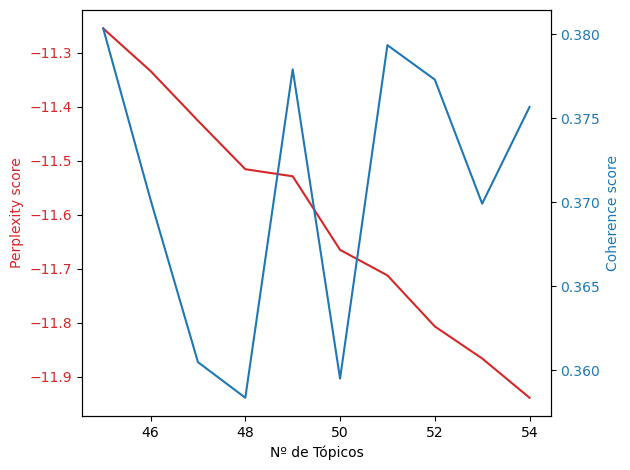

In [77]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=55; start=45; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('AL_Coherence Score_45 - 55 topicos.png')

plt.show()

In [78]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 45  tem um valor de coerência de  0.3803  e valor de perplexidade de -11.2553
A quantidade de tópicos = 46  tem um valor de coerência de  0.3701  e valor de perplexidade de -11.3342
A quantidade de tópicos = 47  tem um valor de coerência de  0.3605  e valor de perplexidade de -11.4261
A quantidade de tópicos = 48  tem um valor de coerência de  0.3584  e valor de perplexidade de -11.5159
A quantidade de tópicos = 49  tem um valor de coerência de  0.3779  e valor de perplexidade de -11.529
A quantidade de tópicos = 50  tem um valor de coerência de  0.3595  e valor de perplexidade de -11.6652
A quantidade de tópicos = 51  tem um valor de coerência de  0.3793  e valor de perplexidade de -11.7125
A quantidade de tópicos = 52  tem um valor de coerência de  0.3773  e valor de perplexidade de -11.8069
A quantidade de tópicos = 53  tem um valor de coerência de  0.3699  e valor de perplexidade de -11.8662
A quantidade de tópicos = 54  tem um valor de coerência de  0.375

In [107]:
# Valor escolhido para coherence score foi 14 tópicos (coherence score = 0.388).
# Número de tópicos
num_topicos = 25

In [108]:
# Inputar os dados e rodar o modelo LDA:
modelo_lda = LdaModel(corpus=corpus,
                      id2word=dicionario,
                      num_topics=num_topicos,
                      random_state=42,
                      per_word_topics=True)

In [109]:
# Imprimir os tópicos:
for topic_id in range(num_topicos):
    print(f"Topic {topic_id}: {modelo_lda.show_topic(topic_id)}")

Topic 0: [('conhec', 0.015588381), ('unidad', 0.0148761105), ('analis', 0.011768698), ('hist', 0.011102837), ('period', 0.010111828), ('difer', 0.009875715), ('espac', 0.009842677), ('tema', 0.008049871), ('objet', 0.00796118), ('rua', 0.007717767)]
Topic 1: [('cienc', 0.01856883), ('afric', 0.016723858), ('ensin', 0.013331743), ('fisic', 0.011337368), ('educaca', 0.010680317), ('estud', 0.010501164), ('sociedad', 0.010455755), ('ingl', 0.009923437), ('antig', 0.009804095), ('formaca', 0.009709564)]
Topic 2: [('numer', 0.016433671), ('transmissa', 0.014238662), ('process', 0.01346184), ('alteraco', 0.011736107), ('expansa', 0.010266005), ('difer', 0.0101564), ('decim', 0.0087612355), ('estud', 0.00861118), ('mudanc', 0.00845322), ('dia', 0.007937112)]
Topic 3: [('cult', 0.021140896), ('histor', 0.017556325), ('conhec', 0.017246436), ('difer', 0.01661128), ('identific', 0.015005975), ('soc', 0.0143179465), ('process', 0.010987448), ('form', 0.010761641), ('lingu', 0.010474258), ('tecnol

### Visualizações:

In [110]:
# Visualização dos tópicos:
visualizacao_BNCC = pyLDAvis.gensim_models.prepare(modelo_lda, corpus, dicionario, n_jobs=1)

In [111]:
# Salvar a visualização como um arquivo HTML:
pyLDAvis.save_html(visualizacao_BNCC, r"AL_visualizacao_BNCC_25_topicos.html")

### Distribuição de palavras por frase:

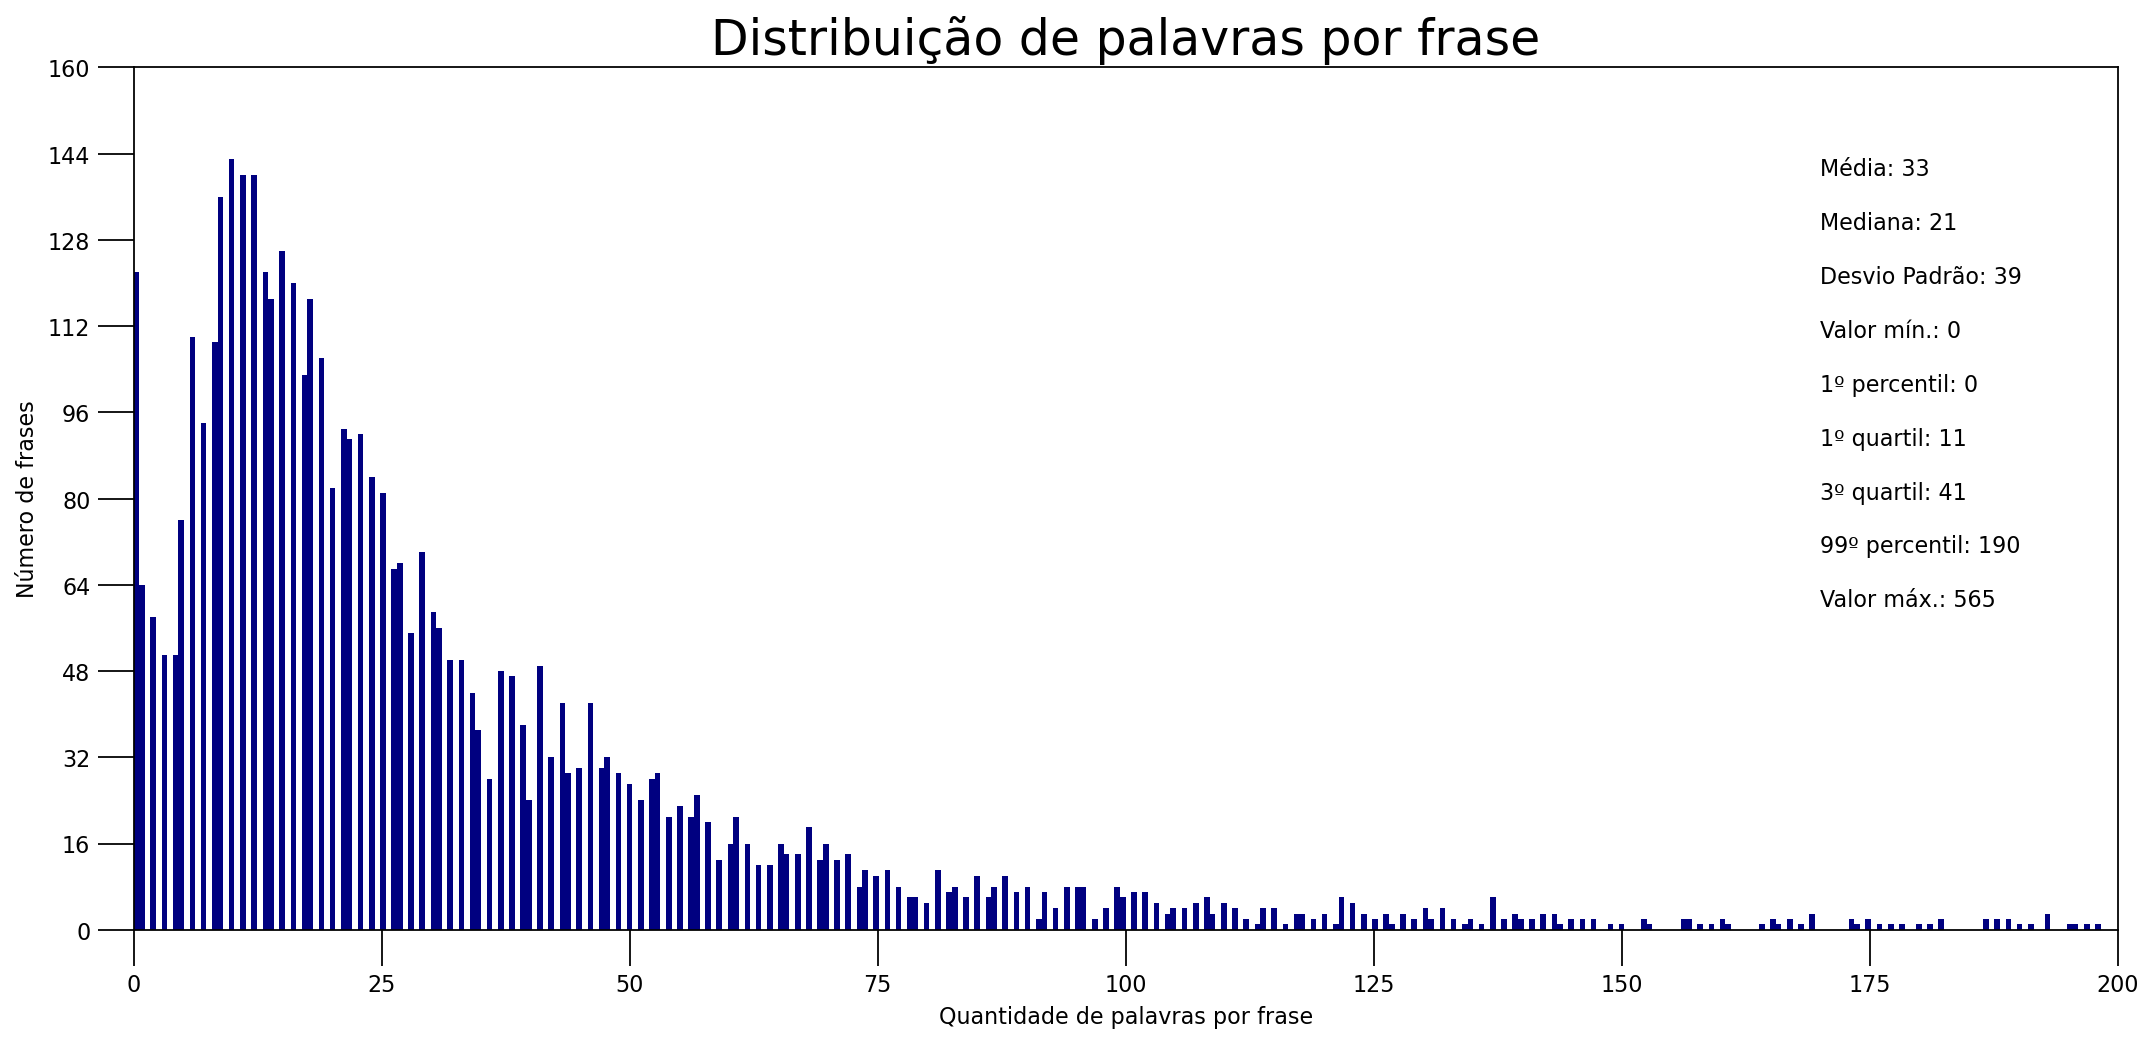

In [113]:
doc_lens = [len(d) for d in df['Stem']]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(170, 140, "Média: " + str(round(np.mean(doc_lens))))
plt.text(170, 130, "Mediana: " + str(round(np.median(doc_lens))))
plt.text(170, 120, "Desvio Padrão: " + str(round(np.std(doc_lens))))
plt.text(170, 110, "Valor mín.: " + str(round(np.min(doc_lens))))
plt.text(170, 100, "1º percentil: " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(170, 90, "1º quartil: " + str(round(np.quantile(doc_lens, q=0.25))))
plt.text(170, 80, "3º quartil: " + str(round(np.quantile(doc_lens, q=0.75))))
plt.text(170, 70, "99º percentil: " + str(round(np.quantile(doc_lens, q=0.99))))
plt.text(170, 60, "Valor máx.: " + str(round(np.max(doc_lens))))

plt.gca().set(xlim=(0, 200), ylim=(0, 160), ylabel='Número de frases', xlabel='Quantidade de palavras por frase')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,200,9))
plt.yticks(np.linspace(0,160,11))
plt.title('Distribuição de palavras por frase', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('AL_Distribuicao_de_palavras_por_frase.png')

plt.show()

### Frequência de palavras em todo o documento:

In [114]:
# Concatenar todas as strings em uma única lista de palavras:
palavras = [palavra for lista in df['Stem'].values for palavra in lista]

# Calcular a frequência das palavras:
freq_dist = FreqDist(palavras)

# Obter as palavras mais frequentes:
top30_palavras = freq_dist.most_common(30)

# Criar um DataFrame com as palavras e suas frequências:
top30_palavras_df = pd.DataFrame(top30_palavras, columns=['Palavra', 'Frequência'])

# Imprimir o DataFrame:
top30_palavras_df

Palavra  Frequência
0        text        1661
1      conhec        1363
2       difer        1216
3       estud        1183
4       lingu        1018
5        cult         997
6   desenvolv         896
7      analis         896
8   identific         878
9       habil         821
10       leit         700
11     utiliz         696
12    trabalh         677
13        soc         666
14     divers         659
15        pra         658
16    produca         649
17    process         646
18        ano         610
19        uso         606
20      ensin         596
21   reconhec         590
22        etc         587
23      gener         580
24      espac         575
25  compreend         553
26    context         532
27      escol         530
28       form         529
29   curricul         521

"pra" é a raiz de prática.

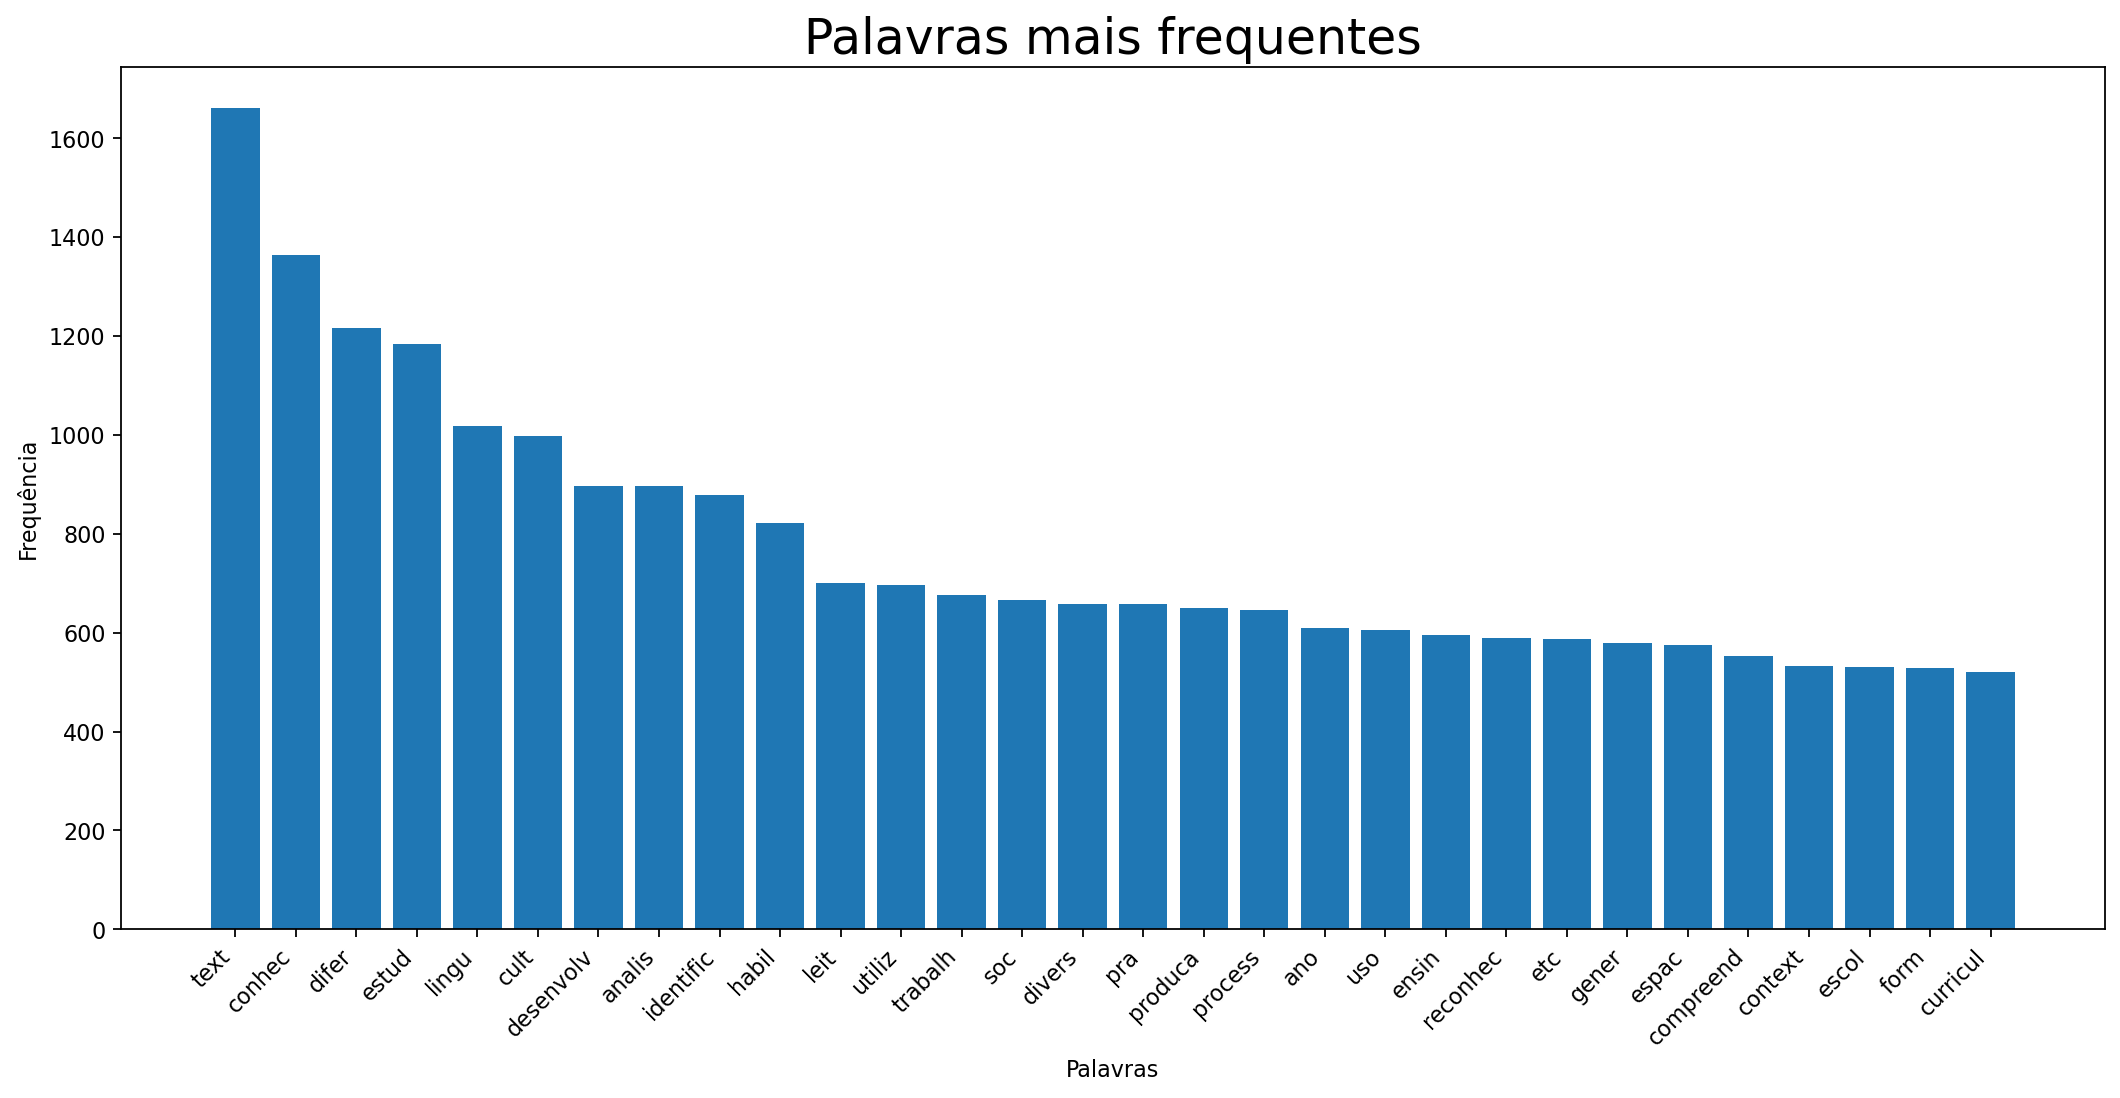

In [115]:
# Criar um gráfico de barras com as palavras mais frequentes:
plt.figure(figsize=(16,7), dpi=160)
plt.bar(top30_palavras_df['Palavra'], top30_palavras_df['Frequência'])
plt.title('Palavras mais frequentes', fontdict=dict(size=22))
plt.xlabel('Palavras')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequência')

# Salvar imagem:
plt.savefig('AL_Palavras mais frequentes.png')

plt.show()

### Nuvem de palavras para todo o documento:

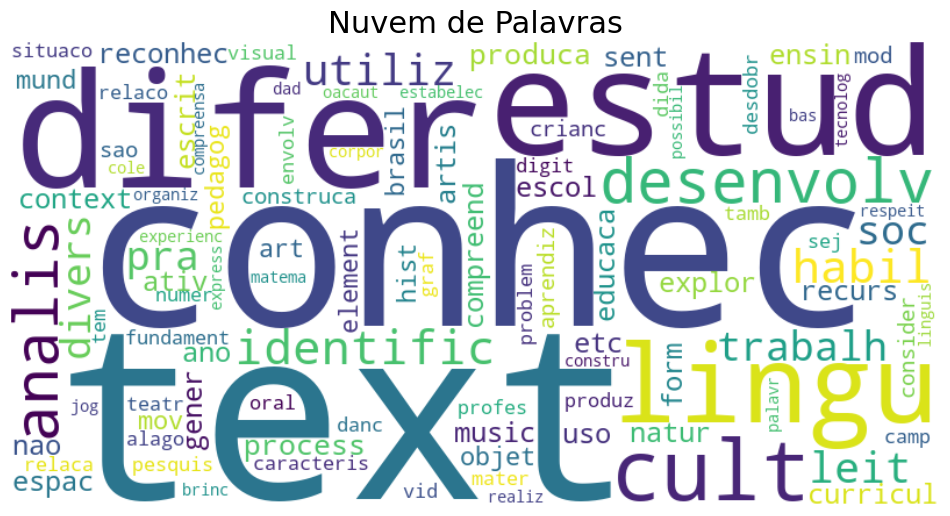

In [116]:
# Criar uma nuvem de palavras:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('AL_Nuvem de palavras_corpus.png')

plt.show()

### Frequência de palavras em cada tópico:

In [117]:
# Criar DataFrame com frequência das palavras no corpus e relevância no tópico:
topics = modelo_lda.show_topics(num_topics=num_topicos, formatted=False)
data_flat = [w for w_list in df['Stem'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_topicos = pd.DataFrame(out, columns=['Stem', 'topic_id', 'relevancia', 'frequencia'])

C:\Users\hugob\AppData\Local\Temp\ipykernel_20940\868649456.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_20940\868649456.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_20940\868649456.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_20940\868649456.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalig

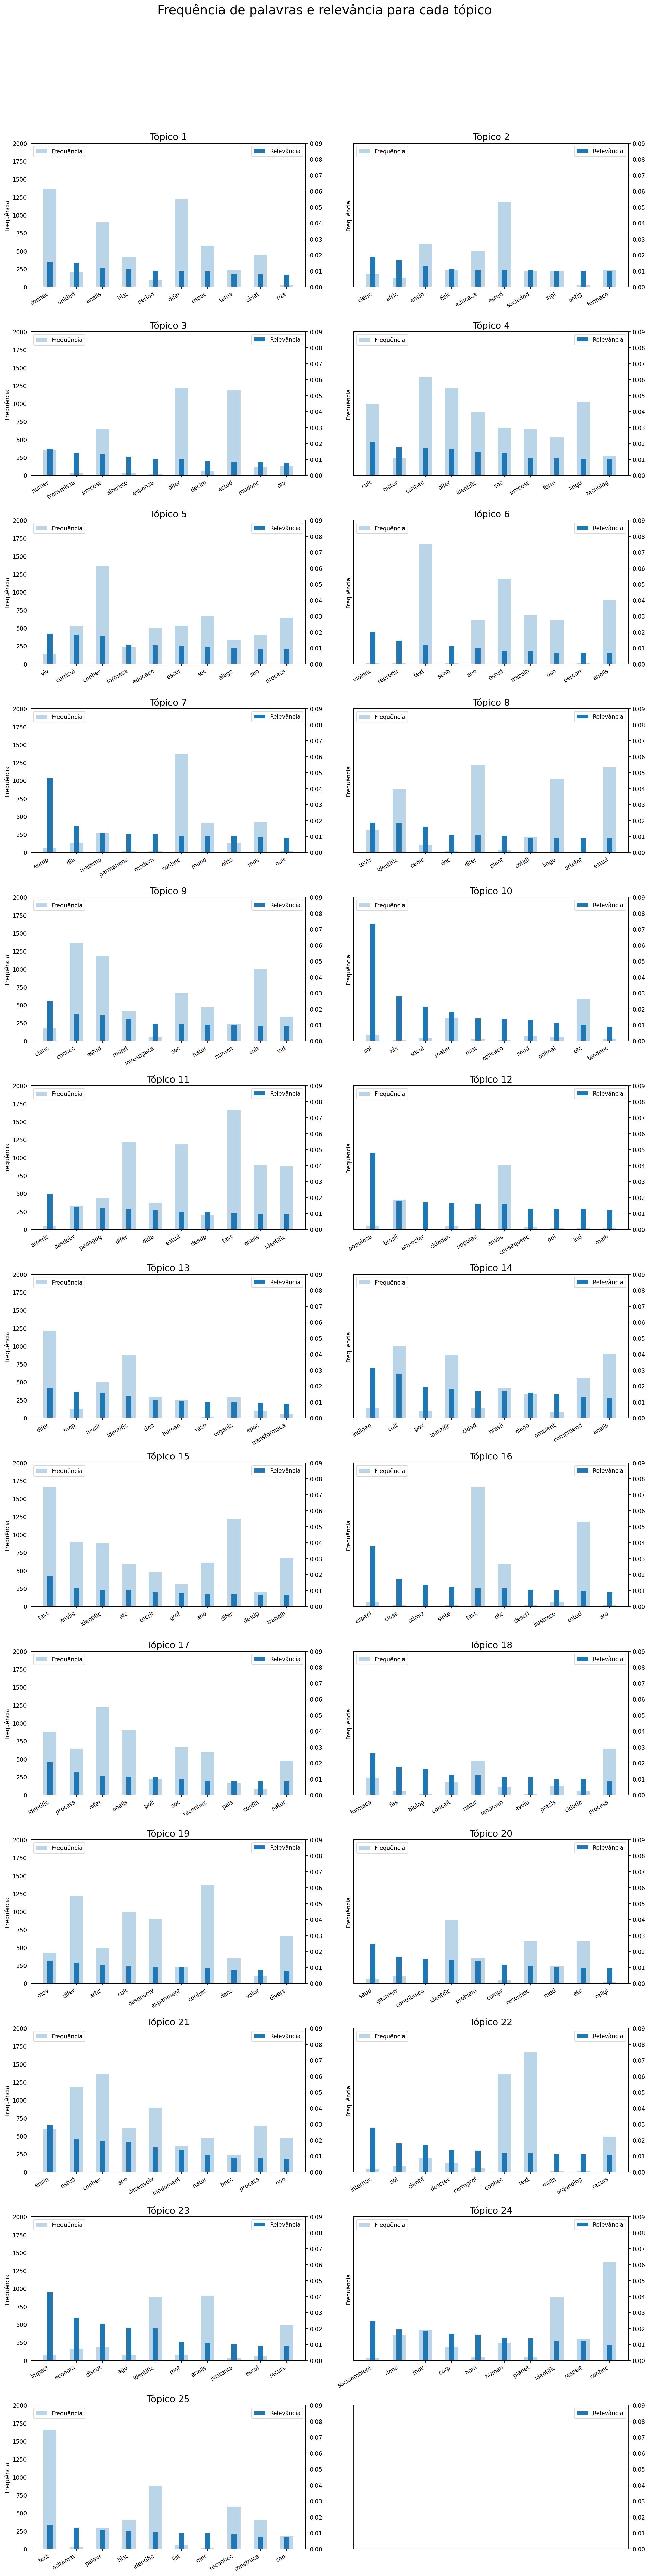

In [122]:
# Plotar contagem de palavras e pesos das palavras mais relevantes:
fig, axes = plt.subplots(13, 2, figsize=(16,60), sharey=True, dpi=160)

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='Stem', height="frequencia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.5, alpha=0.3, label='Frequência')
    ax_twin = ax.twinx()
    ax_twin.bar(x='Stem', height="relevancia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.2, label='Relevância')
    ax.set_ylabel('Frequência')
    ax_twin.set_ylim(0, 0.090); ax.set_ylim(0, 2000)
    ax.set_title('Tópico ' + str(i+1), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

# Excluir o 26º subplot (na 13ª linha e 2ª coluna):
fig.delaxes(axes[12, 1])
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Frequência de palavras e relevância para cada tópico', fontsize=22, y=1.05)

# Salvar imagem:
plt.savefig('AL_Frequencia e relevancia de palavras por topico.png')

plt.show()

### Nuvem de palavras para cada tópico:

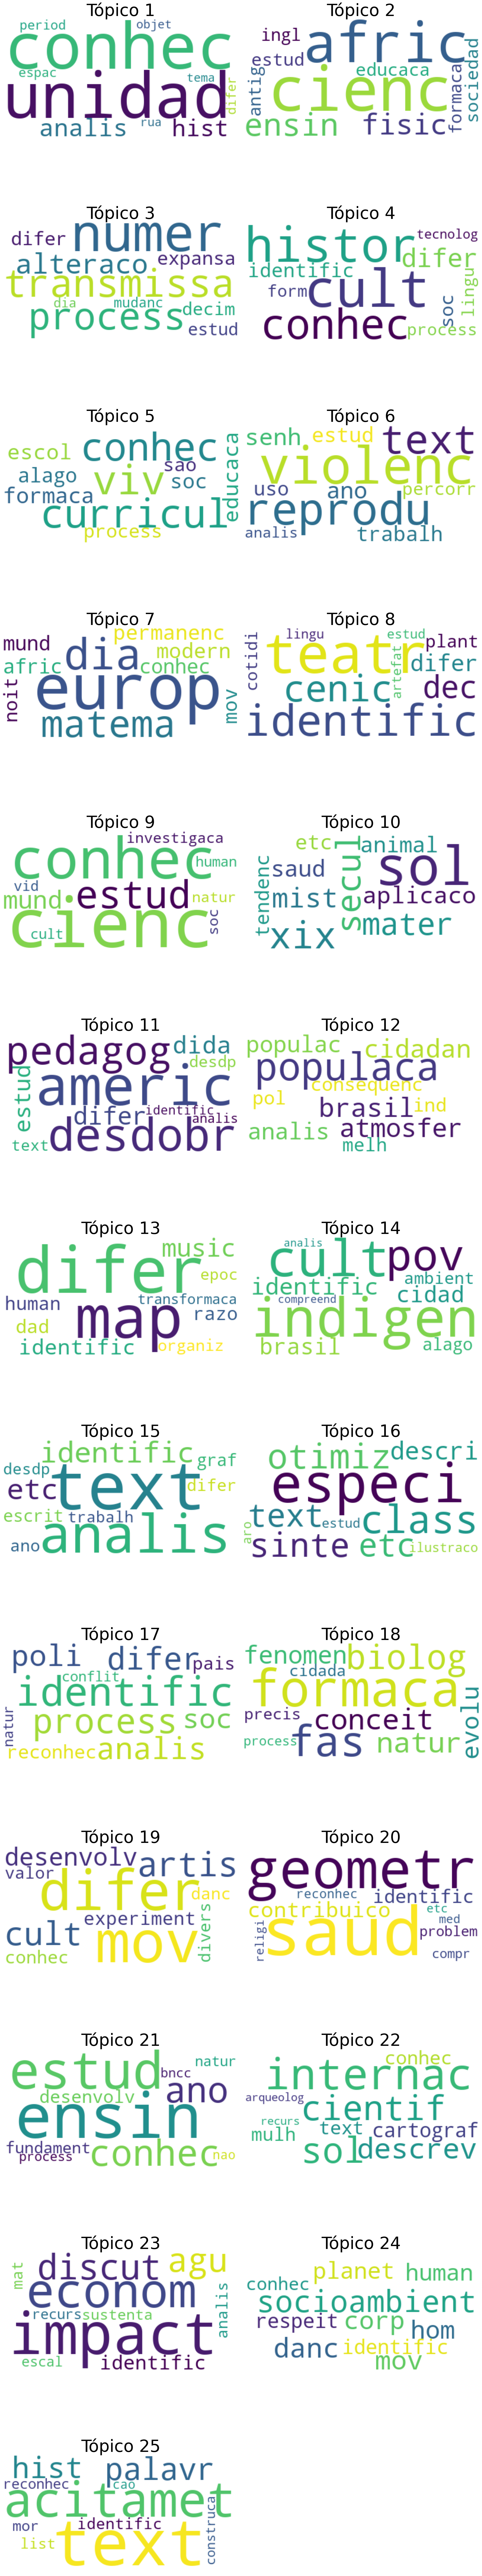

In [119]:
# Configuração do layout dos subplots
num_linhas = 13
num_colunas = 2

# Calcula o número total de subplots necessários
num_subplots = min(num_topicos, num_linhas * num_colunas)

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(20, 110)) 

for topico_id in range(num_subplots):
    # Obter as palavras e frequências associados ao tópico:
    topico_palavras_pesos = modelo_lda.show_topic(topico_id)
    
    # Criar um dicionário de contagem de palavras e pesos:
    contagem_palavras = {palavra: peso for palavra, peso in topico_palavras_pesos}
    
    # Criar o objeto WordCloud:
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(contagem_palavras)
    
    # Adicionar subplot ao layout
    linha = topico_id // num_colunas
    coluna = topico_id % num_colunas
    axs[linha, coluna].imshow(wordcloud, interpolation='bilinear')
    axs[linha, coluna].set_title(f'Tópico {topico_id + 1}', fontdict=dict(size=50))
    axs[linha, coluna].axis('off')

# Colocar o último subplot na última linha entre as duas colunas:
if num_topicos % num_colunas == 1:
    axs[-1, 0].axis('off')  # Desativa os eixos do último subplot na última linha
    axs[-1, 1].remove()     # Remove o último subplot na última linha, segunda coluna
    
# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Salvar imagem:
plt.savefig('AL_Nuvem de palavras por topico.png')

plt.show()